#Lecture 1 - AE, VAE, Latent space

# Theoretical Questions

### TQ1. How could you implement an AutoEncoder (or VAE) for Images? And time series?


The Encoder and Decoder models are always modules that can be freely replaced by any other architecture available. Therefore:

1.   **Image**: We could use a convolutional network to encode and another convolutional network to reconstruct! This is in fact what a ConvAE does, which we will see in the next lecture.
2.   **Time series**: We coud use a recurrent network (LSTM for instance) to encode the data and a decoder LSTM to reconstruct. These, however, are tricky: to reconstruct the time series the only information of the sequence should be the first instant of any given series.



### TQ2. Aside from the limitations listed in class, what are others limitations to AutoEncoders?

Here are some:

*   Autoencoders require heavy parameter optimization with the bottleneck being such a sensitive point in the network.
*   Autoencoders simply learn to reduce the dimensions, nothing else necessarily. Nothing is learnt about input data beyond what is useful/what isn't.
*   As they are trained with the same inputs and outputs, they are more prone to overfitting than the regular neural models. If you use the model simply as a compressor (to reduce the dimensionality of some data) it may be fine, but otherwise good results cannot be guaranteed.



### TQ3. What effect does the bottleneck have in the network?

The bottleneck is, in few words, the 'compression rate' of the network. AutoEncoders compare try to obtain the inputs from themselves, so if the compression rate is 1.0 (the amount of bytes/information used in the original image is the same) then the compression is useless. This principle can be applied to AutoEncoders.

the tradeoff is: high compression means loss of information, low compression means that the compression may be useless or trivial. Therefore, we want to have small bottlenecks while having just barely enough information to reproduce the inputs.

### TQ4. Imagine we want to build an AutoEncoder to fix missing data. Assume we have a reasonably sized dataset with enough non-faulty data to train this AutoEncoder and a massive dataset to fix.

The simplest approach would be to use the high-quality data to build an AutoEncoder. However, to train this Autoencoder we would need to artificailly break the input data to approximate the use-case. Consider the following sequence of operations, where $E(⋅)$ and $D(⋅)$ is the encoder.


1.   Let $X$ be some input data.
2.   Let $B$ be an algorithm that generates broken/missing data
3.   $X' ⟵ B(X)$
4.   $L  ⟵ E(X')$
5.   $Y'  ⟵ D(L)$
6.   Compute $ℒ(Y', X)$, however only use the loss from corrupted data, as it is the really important losses.

This is a single example as to how to use the Encoder-Decoder architecture to fix categorical data.


# Code Exercises

**Dependencies**

In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 19.1 MB/s eta 0:00:00


Load your drive using this (if necessary):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Set up dependencies of the notebook

In [2]:
import datetime

import torch
import torch.nn as nn

import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning import seed_everything

import numpy as np

import pandas as pd

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

### Data Loading
Data loading is done here to simplify the coding exercises. The Data Loading and most of the training will remain the same. However, some changes will be required.

In [3]:
DATA_PATH = 'mushrooms.csv'
SEED = 42
seed_everything(seed=SEED) # Set seed for reproducibility,

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

Load the dataset

In [5]:
mush_df = pd.read_csv(DATA_PATH) # Drop the class,
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Now, quicly perform the One Hot Encoding with sklearn `sklearn.preprocessing.OneHotEncoder`



In [6]:
ohe = OneHotEncoder(sparse_output=False)

mush_df_train = mush_df.drop('class', axis=1).copy()
new_data = ohe.fit_transform(mush_df_train)
mush_df_train = pd.DataFrame(new_data, columns=ohe.get_feature_names_out())
mush_df_train


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8120,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8121,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8122,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Torch dataset

In [7]:
class MushroomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.tensor(self.df.iloc[idx].values, dtype=torch.float32)

Finally, declare the `pl.LightningDataModule`

In [8]:
class MushroomModule(pl.LightningDataModule):
    def __init__(self, df, batch_size=16, val_size=0.2):
        super().__init__()
        self.batch_size = batch_size
        self.val_size = val_size
        self.full_len = len(df)
        self.df = df

    def setup(self, stage=None):
        # We can't perform numerical evaluations! Only train + val
        train_end = int((1 - self.val_size) * self.full_len)
        self.train_data = MushroomDataset(self.df[:train_end])
        self.val_data = MushroomDataset(self.df[train_end:])

    def collate_fn(self, batch):
        features = torch.stack(batch, axis=0)  # [batch_size, input_size]
        return features

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)

## CQ1 (✰). Improving the autoencoder

In the Lecture we made a basic AutoEncoder, however, this autoencoder is severely flawed and can be improved upon with better design decisions along the Encoder-Decoder architecture.

1.   Labels are one hot encodings, ranging from 0 to 1; if the network outputs conform to these ranges, it can be expected to perform better. Specially with MSE loss. There's a catch to this, though...
2.   ... Several positions of the output vector match with a single feature. Measuring MSE is ill-fitted, as there are several classification tasks we could use a loss term for each classification task at the same time.

Intorduce any desired changes to the network. Generalize the number of layers it may have, include regularization... include your own improvements.



In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_dim, bottleneck):
        super(Encoder, self).__init__()
        self.encoder_layer = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck),
            nn.BatchNorm1d(bottleneck),
        )

    def forward(self, x):
        return self.encoder_layer(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, bottleneck, hidden_dim, output_size):
        super(Decoder, self).__init__()
        self.decoder_layer = nn.Sequential(
            nn.Linear(bottleneck, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_size),
        )

    def forward(self, x):
        return self.decoder_layer(x)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_dim, bottleneck):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_size, hidden_dim, bottleneck)
        self.decoder = Decoder(bottleneck, hidden_dim, input_size)

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output, latent # The utility of this network is getting the latent!

### Training

Introduce any new change you want in the `compute_batch` method.

In [ ]:
class MushroomCompressor(pl.LightningModule):
    def __init__(self, model, categories, learning_rate=1e-3, weight_decay=0.):
        super(MushroomCompressor,self).__init__()
        self.save_hyperparameters() # Save Hyperparams
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.nrmse = torchmetrics.NormalizedRootMeanSquaredError()
        self.mse = nn.MSELoss()
        self.categories = categories # New property, required for advanced train

    def forward(self, x):
        return self.model(x)

    def compute_batch(self, batch, split='train'):
        # Here is an important part!
        # Observe the inputs and targets are the exact same!!!
        inputs = batch
        output, _ = self(inputs)

        preds = output
        targets = inputs

        i = 0
        loss = 0

        for cat in self.categories:
          start, end = i, i + len(cat)
          preds_cat = preds[:, start:end]
          targets_cat = targets[:, start:end].argmax(dim=-1)
          loss += self.criterion(preds, targets)
          i = end

        loss /= len(self.categories)

        self.log_dict(
            {
                f'{split}_loss': loss,
                f'{split}_nrmse': self.nrmse(preds, targets),
                f'{split}_mse': self.mse(preds, targets),
            },
            on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')

    def predict_step(self, batch, batch_idx):
        return self(batch)[-1]

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate,
                                 weight_decay=self.weight_decay) # self.parameters() son los parámetros del modelo

In [ ]:
#@title Hyper-parameters

LEARNING_RATE = 1e-3 #@param {type:"number"}
WEIGHT_DECAY = 0. #@param {type:"number"}
BATCH_SIZE = 8 # @param ["2","4","8","16","32"] {"type":"raw"}
MAX_EPOCHS = 10 # @param {"type":"slider","min":0,"max":100,"step":1}
HIDDEN_DIM = 32 # @param {"type":"slider","min":0,"max":128,"step":1}
LATENT_DIM = 3 # @param {"type":"slider","min":0,"max":16,"step":1}

SAVE_DIR = f'lightning_logs/sales/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'


#### Train loop

In [ ]:
# DataModule
data_module = MushroomModule(mush_df_train, batch_size=BATCH_SIZE)

# Model
model = AutoEncoder(input_size=mush_df_train.values.shape[1], hidden_dim=HIDDEN_DIM, bottleneck=LATENT_DIM)

# LightningModule
module = MushroomCompressor(model, ohe.categories_, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Callbacks
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min',
    patience=5, # número de epochs sin mejora antes de parar
    verbose=False, # si queremos que muestre mensajes del estado del early stopping
)
model_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    save_top_k=1, # guardamos solo el mejor modelo
    dirpath=SAVE_DIR, # directorio donde se guardan los modelos
    filename=f'best_model' # nombre del archivo
)

callbacks = [early_stopping_callback, model_checkpoint_callback]

# Loggers
csv_logger = pl.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator='gpu', callbacks=callbacks,
                     logger=loggers, precision='bf16')

trainer.fit(module, data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:572: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/lightning_logs/sales/2025-01-08_15-27-39 exists and is not empty.
INFO:pyt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Visualization
Lets explore the latent space!

In [ ]:
embeddings = trainer.predict(module, torch.utils.data.DataLoader(MushroomDataset(mush_df_train), batch_size=16))
embeddings = torch.cat(embeddings).to(torch.float).cpu().numpy()
embeddings

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[ 1.15625   , -2.515625  ,  3.03125   ],
       [-1.5546875 , -0.671875  ,  3.09375   ],
       [-1.4765625 , -0.375     ,  3.078125  ],
       ...,
       [-1.109375  ,  1.5625    ,  0.765625  ],
       [-2.0625    ,  2.1875    , -0.92578125],
       [-1.125     ,  1.671875  ,  0.78515625]], dtype=float32)

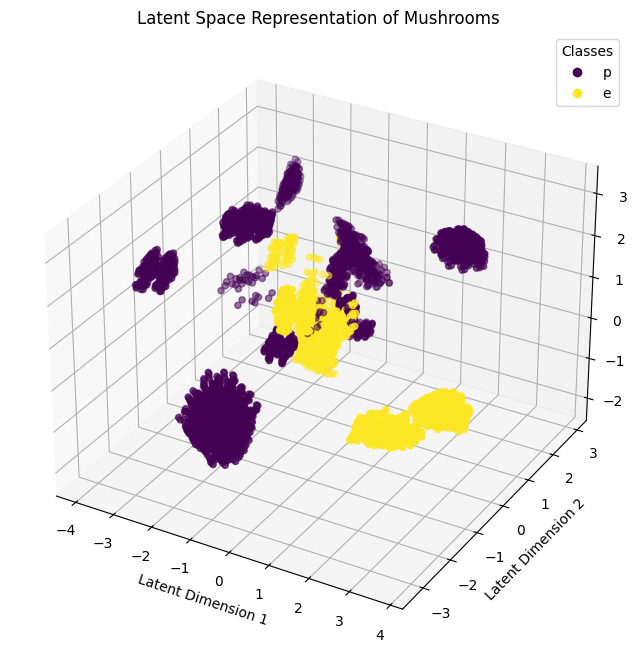

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# You can visualize a 3d space with this!
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

classes = mush_df['class']

scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=classes.astype('category').cat.codes)

ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")
ax.set_title("Latent Space Representation of Mushrooms")

handles, labels = scatter.legend_elements()
ax.legend(handles, classes.unique(), title="Classes")

plt.show()

## CQ2 (✰✰). Implement the VAE for the mushroom dataset

We have seen that VAEs overcome the problems of AE by generating a continuous latent space. We implement here this VAE model. The VAE generates the average and deviation of a distribution, instead of a point. We need to implement an encoder that performs exactly that task.

We have to build $σ(x)$ and $μ(x)$, these transformations operate on $x$ (the original latent representation), the earlier point that was generated by the encoder. Use a Linear layer to let the model decide where's the average of $x$ and another Linear layer to let the model decide what's the deviation of $x$.

**Note**: For better results we use the logarithmic deviation. This, however, does not affect the encoder.



### VAE definition

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_dim, bottleneck):
        super(Encoder, self).__init__()
        self.encoder_layer = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck),
            nn.BatchNorm1d(bottleneck),
        )
        self.mu = nn.Linear(bottleneck, bottleneck)
        self.sigma = nn.Linear(bottleneck, bottleneck)

    def forward(self, x):
        latent = self.encoder_layer(x)
        mu = self.mu(latent)
        sigma = self.sigma(latent) # Logarithmic deviation.
        return mu, sigma

Now, the decoder will continue being the same, it receives a latent representation and generates a mushroom. Same as before.

In [17]:
class Decoder(nn.Module):
    def __init__(self, bottleneck, hidden_dim, output_size):
        super(Decoder, self).__init__()
        self.decoder_layer = nn.Sequential(
            nn.Linear(bottleneck, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_size),
        )

    def forward(self, x):
        return self.decoder_layer(x)

However, there is a mismatch now. The encoder outputs a distribution of points, while the decoder takes a single point. Thus, the Encoder-Decoder should sample the distribution of the encoder using $μ(x)$ and $σ(x)$!

However, sampling is non-differentiable, we need the **reparametrization trick**. Normally we would use `torch.normal(mean=μ(x), std=σ(x))`, however we will use a different expression.

The reparamerization trick involves using `torch.randn(bottleneck)` to obtain a random vector to operate with the average and deviation.

$$x_{sampled} = μ(x) + N(0,1) \cdot e^{0.5*σ(x)}  $$

Or, the exact same would be multiplying the deviation ($\sigma(x)$) by a standard normal random distribution ($N(0,1)$) then summing the mean $\mu(x)$.

To train we also need to retrieve the deviation and mean!

In [18]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_dim, bottleneck):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_dim, bottleneck)
        self.decoder = Decoder(bottleneck, hidden_dim, input_size)

    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = mu + torch.randn_like(sigma) * torch.exp(0.5 * sigma)
        output = self.decoder(latent)
        return output, (mu, sigma)

### Training

The new loss term is different from before. We use:

$$ℒ(x',x) = ℒ_{rec}(x', x) + λℒ_{kl}(\mu(x), \sigma(x))$$

This is a sum of the reconstruction loss (Whatever loss we choose, MSE, CE, etc) and the Kullback–Leibler loss (KL Div.). $x$ are the inputs, $x'$ is the reconstruction.

Modify `_rec_loss(self, preds, targets)` and  `_kl_loss(self, mu, sigma)` to build the new `compute_batch(self, batch)`.

You can use either the torch implementation of the [KL-Divergence](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#torch.nn.KLDivLoss) or code it yourself!

In [59]:
class MushroomGenerator(pl.LightningModule):
    def __init__(self, model, categories, learning_rate=1e-3, weight_decay=0., lambd=1.):
        super(MushroomGenerator,self).__init__()
        self.save_hyperparameters() # Save Hyperparams
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.model = model
        self.reconstruction = nn.CrossEntropyLoss()
        self.nrmse = torchmetrics.NormalizedRootMeanSquaredError()
        self.mse = nn.MSELoss()
        self.lambd = lambd # Weights the influence of the KLDiv
        self.categories = categories

    def forward(self, x):
        return self.model(x)

    def _rec_loss(self, preds, targets):
        i = 0
        rec_loss = 0

        for cat in self.categories:
          start, end = i, i + len(cat)
          preds_cat = preds[:, start:end]
          targets_cat = targets[:, start:end].argmax(dim=-1)
          rec_loss += self.reconstruction(preds, targets)
          i = end

        return rec_loss / len(self.categories)

    def _kl_loss(self, mu, sigma):
        return torch.mean(-0.5 * torch.sum(1 + sigma - mu ** 2 - sigma.exp(), dim = 1), dim = 0)

    def compute_batch(self, batch, split='train'):
        inputs = batch
        output, (mu, sig) = self(inputs)

        preds = output
        targets = inputs
        rec_loss = self._rec_loss(preds, targets)
        kl_loss = self._kl_loss(mu, sig)
        loss =  rec_loss + self.lambd * kl_loss#.clamp(min=-10, max=10)

        self.log_dict(
            {
                f'{split}_loss': loss,
                f'{split}_rec_loss': rec_loss,
                f'{split}_kl_loss': -kl_loss,
                f'{split}_nrmse': self.nrmse(preds, targets),
                f'{split}_mse': self.mse(preds, targets),
            },
            on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')

    def predict_step(self, batch, batch_idx):
        return self(batch)[-1][0]

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate,
                                 weight_decay=self.weight_decay)

In [60]:
#@title Hyper-parameters

LEARNING_RATE = 1e-3 #@param {type:"number"}
WEIGHT_DECAY = 0. #@param {type:"number"}
BATCH_SIZE = 8 # @param ["2","4","8","16","32"] {"type":"raw"}
MAX_EPOCHS = 10 # @param {"type":"slider","min":0,"max":100,"step":1}
HIDDEN_DIM = 32 # @param {"type":"slider","min":0,"max":128,"step":1}
LATENT_DIM = 3 # @param {"type":"slider","min":0,"max":16,"step":1}
LAMBDA = 1 #@param {type:"number"}

SAVE_DIR = f'lightning_logs/sales/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'


### Run!

In [61]:
# DataModule
data_module = MushroomModule(mush_df_train, batch_size=BATCH_SIZE)

# Model
model = VAE(input_size=mush_df_train.values.shape[1], hidden_dim=HIDDEN_DIM, bottleneck=LATENT_DIM)

# LightningModule
module = MushroomGenerator(model, ohe.categories_,
                           learning_rate=LEARNING_RATE,
                           weight_decay=WEIGHT_DECAY,
                           lambd=LAMBDA)

# Callbacks
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min',
    patience=5, # número de epochs sin mejora antes de parar
    verbose=False, # si queremos que muestre mensajes del estado del early stopping
)
model_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    save_top_k=1, # guardamos solo el mejor modelo
    dirpath=SAVE_DIR, # directorio donde se guardan los modelos
    filename=f'best_model' # nombre del archivo
)

callbacks = [early_stopping_callback, model_checkpoint_callback]

# Loggers
csv_logger = pl.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator='gpu', callbacks=callbacks,
                     logger=loggers, precision='bf16')

trainer.fit(module, data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:572: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/lightning_logs/sales/2025-01-10_12-42-20 exists and is not empty.
INFO:pyt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [62]:
embeddings = trainer.predict(module, torch.utils.data.DataLoader(MushroomDataset(mush_df_train), batch_size=16))
embeddings = torch.cat(embeddings).to(torch.float).cpu().numpy()
embeddings

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[-0.68359375,  1.1171875 ,  0.32226562],
       [-0.46289062,  1.78125   , -0.15820312],
       [-0.31054688,  1.90625   , -0.2734375 ],
       ...,
       [-0.515625  ,  0.22558594, -0.9765625 ],
       [-1.3984375 , -0.51171875, -1.4609375 ],
       [-0.5546875 ,  0.18164062, -0.9140625 ]], dtype=float32)

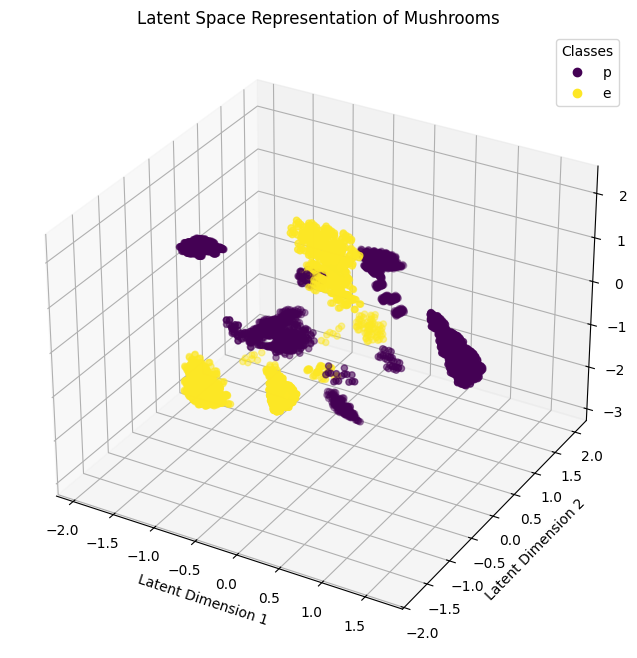

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# You can visualize a 3d space with this!
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

classes = mush_df['class']

scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=classes.astype('category').cat.codes)

ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")
ax.set_title("Latent Space Representation of Mushrooms")

handles, labels = scatter.legend_elements()
ax.legend(handles, classes.unique(), title="Classes")

plt.show()

At this point you won't notice any difference between the AE and the VAE... and that's okay. It's difficult to understand the point of the VAE with categorical data, it will be apparent in the next Lecture with images.